# **Pemodelan Analisis Sentimen Menggunakan Logistic Regression**

Notebook ini berisi proses pemodelan analisis sentimen menggunakan representasi fitur TF-IDF dan algoritma Logistic Regression. Tahapan meliputi pembuatan model baseline, hyperparameter tuning, evaluasi performa model, serta penyimpanan model terbaik untuk keperluan inferensi dan integrasi ke aplikasi GUI.

## **Import Library**

In [1]:
# Manipulasi data
import pandas as pd
import numpy as np

# Machine Learning dan evaluasi
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Simpan dan load model
import pickle

## **Load Dataset Hasil Preprocessing**

In [5]:
# Memuat dataset yang telah melalui tahap preprocessing
df = pd.read_csv('dataset_preprocessed.csv')

# Menampilkan ukuran dataset dan beberapa data awal
print("Jumlah data (baris, kolom):", df.shape)
df.head()


Jumlah data (baris, kolom): (40384, 2)


,clean_text,sentiment_num
0,barang sesuai pesan cepat,1
1,barang bagus harga murah,1
2,paket rapimantapcepatsampe tuju,1
3,ya puas dgn barang,1
4,responya b mantap,1


## **Distribusi Kelas Sentimen**

/tmp/ipython-input-2858675507.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Positive', 'Neutral', 'Negative'])


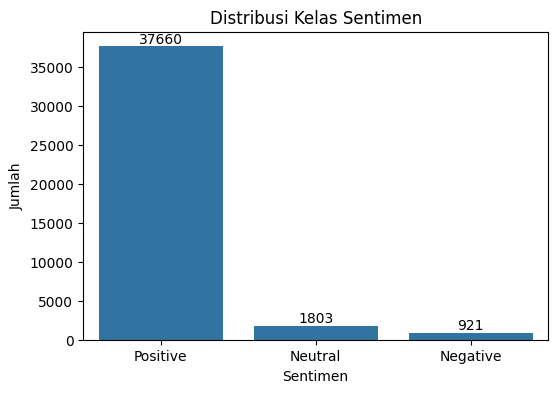

In [6]:
# Visualisasi distribusi kelas sentimen
plt.figure(figsize=(6,4))
ax = sns.countplot(
    x='sentiment_num',
    data=df,
    order=[1, 0, -1]
)

# Mengganti label numerik menjadi label teks
ax.set_xticklabels(['Positive', 'Neutral', 'Negative'])

plt.title('Distribusi Kelas Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')

# Menampilkan jumlah data pada setiap kelas
for p in ax.patches:
    ax.annotate(
        int(p.get_height()),
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom'
    )

plt.show()

## **Split Data (Training & Testing)**

In [7]:
# Menentukan fitur (X) dan label (y)
X = df['clean_text']
y = df['sentiment_num']

# Membagi data menjadi data training dan testing
X_train, X_test, y_train, y_test = train_test_split(
X, y,
test_size=0.2,
random_state=42,
# untuk menjaga proporsi kelas sentimen
stratify=y
)

print("Jumlah data training:", X_train.shape[0])
print("Jumlah data testing:", X_test.shape[0])

Jumlah data training: 32307
Jumlah data testing: 8077


## **Baseline Model**

Model baseline digunakan sebagai pembanding awal sebelum dilakukan proses hyperparameter tuning.

In [8]:
# Inisialisasi TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2)
)

# Transformasi teks menjadi vektor TF-IDF
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Inisialisasi model Logistic Regression baseline
baseline_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)

# Melatih model menggunakan data training
baseline_model.fit(X_train_tfidf, y_train)

# Prediksi data training
y_train_pred_baseline = baseline_model.predict(X_train_tfidf)

# Prediksi data testing
y_pred_baseline = baseline_model.predict(X_test_tfidf)

# Hitung akurasi training dan testing
train_acc_baseline = accuracy_score(y_train, y_train_pred_baseline)
test_acc_baseline = accuracy_score(y_test, y_pred_baseline)

# Tampilkan hasil evaluasi
print("Baseline Model Performance")
print("--------------------------")
print("Training Accuracy :", train_acc_baseline)
print("Testing Accuracy  :", test_acc_baseline)
print("\nClassification Report (Testing Data):")
print(classification_report(
    y_test,
    y_pred_baseline,
    target_names=['Negative', 'Neutral', 'Positive']
))

Baseline Model Performance
--------------------------
Training Accuracy : 0.8441823753366143
Testing Accuracy  : 0.7920019809335149

Classification Report (Testing Data):
              precision    recall  f1-score   support

    Negative       0.19      0.50      0.28       184
     Neutral       0.11      0.39      0.18       361
    Positive       0.97      0.82      0.89      7532

    accuracy                           0.79      8077
   macro avg       0.43      0.57      0.45      8077
weighted avg       0.92      0.79      0.84      8077



### Confusion Matrix Model Baseline

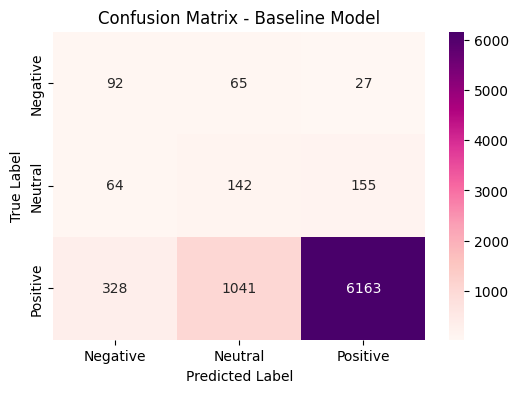

In [9]:
# Membuat confusion matrix untuk model baseline
cm_baseline = confusion_matrix(y_test, y_pred_baseline)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm_baseline,
    annot=True,
    fmt='d',
    cmap='RdPu',
    xticklabels=['Negative', 'Neutral', 'Positive'],
    yticklabels=['Negative', 'Neutral', 'Positive']
)

plt.title('Confusion Matrix - Baseline Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## **Hyperparameter Tuning Menggunakan GridSearchCV**

In [10]:
# Pipeline untuk menggabungkan TF-IDF dan Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

# Daftar hyperparameter yang akan diuji
param_grid = {
    'tfidf__max_features': [3000, 5000, 7000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__solver': ['liblinear', 'lbfgs'],
    'clf__class_weight': ['balanced']
}

# Inisialisasi GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

# Melakukan training dan tuning pada data training
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1, 10],
                         'clf__class_weight': ['balanced'],
                         'clf__solver': ['liblinear', 'lbfgs'],
                         'tfidf__max_features': [3000, 5000, 7000],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1_macro', verbose=2)

### Hasil Hyperparameter Tuning

In [11]:
# Menampilkan kombinasi hyperparameter terbaik
print("Best Parameters:")
print(grid_search.best_params_)

# Menampilkan nilai F1-score terbaik dari cross-validation
print("\nBest CV F1-score:")
print(grid_search.best_score_)

Best Parameters:
{'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__solver': 'liblinear', 'tfidf__max_features': 7000, 'tfidf__ngram_range': (1, 2)}

Best CV F1-score:
0.5232019937254699


### Evaluasi Model Terbaik pada Data Testing

In [12]:
# Mengambil model terbaik hasil GridSearch
best_model = grid_search.best_estimator_

# Prediksi data training
y_train_pred_best = best_model.predict(X_train)

# Prediksi data testing
y_pred_best = best_model.predict(X_test)

# Hitung akurasi training dan testing
train_acc_best = accuracy_score(y_train, y_train_pred_best)
test_acc_best = accuracy_score(y_test, y_pred_best)

# Tampilkan hasil evaluasi
print("Best Model Performance")
print("----------------------")
print("Training Accuracy :", train_acc_best)
print("Testing Accuracy  :", test_acc_best)
print("\nClassification Report (Testing Data):")
print(classification_report(
    y_test,
    y_pred_best,
    target_names=['Negative', 'Neutral', 'Positive']
))

Best Model Performance
----------------------
Training Accuracy : 0.9458321725941746
Testing Accuracy  : 0.9177912591308655

Classification Report (Testing Data):
              precision    recall  f1-score   support

    Negative       0.36      0.42      0.39       184
     Neutral       0.24      0.16      0.19       361
    Positive       0.96      0.97      0.96      7532

    accuracy                           0.92      8077
   macro avg       0.52      0.52      0.51      8077
weighted avg       0.91      0.92      0.91      8077



### Confusion Matrix Model Terbaik

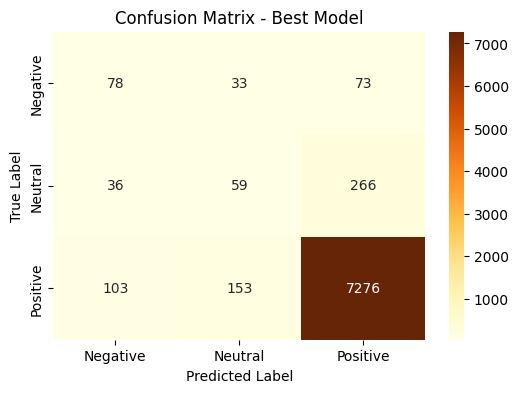

In [13]:
# Membuat confusion matrix untuk model terbaik
cm_best = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm_best,
    annot=True,
    fmt='d',
    cmap='YlOrBr',
    xticklabels=['Negative', 'Neutral', 'Positive'],
    yticklabels=['Negative', 'Neutral', 'Positive']
)

plt.title('Confusion Matrix - Best Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## **Simpan Model Terbaik**

Model terbaik disimpan dalam format .pkl dan siap digunakan untuk proses inferensi maupun integrasi ke dalam aplikasi GUI.

In [14]:
# Ambil tfidf dari best pipeline
tfidf_best = best_model.named_steps['tfidf']
clf_best = best_model.named_steps['clf']

# Simpan TF-IDF
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_best, f)

# Simpan model Logistic Regression
with open('best_model_logistic_regression.pkl', 'wb') as f:
    pickle.dump(clf_best, f)

print("Model dan TF-IDF berhasil disimpan.")

Model dan TF-IDF berhasil disimpan.
